# Introduction

## Context

* Planete OUI offers green electricity supply with prices adapted to the consumption profiles of its clients. 
* The electricity prices are highly variable during time (depending on the market, the global consumption and its client needs).
* The consumption profile of an installation has to be appraised to compute the best estimation of supply tarifs 
    * Most sites have a consumption varying strongly with temperature because of electrical heating systems.
    * Except industrial installations because their consumption might be highly related their uses

The 1st objectives are to __analyze thermosensitivity uses and / or other factors (times series...)__ affecting consumption 

Based on:
* the potential client historical consumption data (i.e its profile)
* electricity prices 
* a given percentile used to cover supply costs for different scenarios
the 2nd objective of Planète OUI is to compute a distribution of supply costs in €/MWh.  

## Planète OUI needs

Extrapolation of one or several years consumption data rebuilt from a single year of measured data supplied by the client (in order to be Tcombined with electricity prices) and to get a larger data set of analysis.

## Data

* The client’s data is often incomplete and spread over a relatively short period.
* 3 datasets:
    * x_train : input data of the training set
    * y_train : output data of the training set
    * x_test : input data of the testing set
* Features:
    * "ID": Data point ID;
    * "timestamp": Complete timestamps with year, month, day and hour, in local time (CET and CEST);
    * "temp1", "temp2", "meannationaltemp": Local and mean national temperatures (°C);
    * "humidity1", "humidity2": Local relative humidities (%);
    * "loc1", "loc2" "locsecondary1", "locsecondary2", "locsecondary3": the coordinates of the studied and secondary sites, in decimal degrees and of the form (latitude, longitude).
    * "consumptionsecondary1", "consumptionsecondary2", "consumptionsecondary3": the consumption data of three secondary sites, whose correlations with studied sites may be of use (kWh). Indeed, the two studied sites and the three secondary sites are used for the same purposes; The output data of the model to be developed takes the following form:
        * "ID": Data point ID;
        * "consumption1", "consumption2": the consumption data of the two studied sites (kWh).

Relative humidities are provided with temperature data because they represent variables of importance for electricity consumption: humidity indeed strongly available for all. It has
influences thermal comfort. To replicate operational conditions, some temperature integrated BCM Energy’s
and humidity data points will be missing. The imputation method must be carefully perimeter in 2017.
considered. The "consumptionsecondaryi" variables are the consumption data of several sites with metering power higher than 250 kVA of the Planète OUIs portfolio.

This correlation of the various sites consumptions shall be studied to precise data
completion or interpolation. Timestamps may be expressed as month or day of year,
day of week and hours, to study the impact of annual, weekly and daily seasonalities.
Particular attention should be paid to national holidays processing.

## Challenge goal

Prediction of the consumption of two given sites during a year, based on measured data of other profiles.

---

# First data insight

## Basic infos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', 100)

In [127]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error # f1_score, classification_report, auc, precision_recall_curve, 
from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA
#from sklearn.manifold import TSNE
from sklearn.linear_model import Lasso, ElasticNet, ridge_regression, LinearRegression, Ridge
from sklearn.ensemble import AdaBoostRegressor #GradientBoostingRegressor, BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, 
from sklearn.svm import SVR

In [4]:
import folium

In [163]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, GRU

In [5]:
file_path = os.path.join('..', '..', 'data', 'final_project')
print(os.listdir(file_path))

['output_training_Uf11I9I.csv', 'vacances-scolaires.csv', 'jours_feries_seuls.csv', 'BCM_custom_metric.py', 'input_test_cdKcI0e.csv', 'input_training_ssnsrY0.csv']


In [6]:
# each id is unique so we can use this column as index
df = pd.read_csv(os.path.join(file_path, 'input_training_ssnsrY0.csv'), index_col='ID')
df.iloc[23:26]

,timestamp,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,loc_1,loc_2,loc_secondary_1,loc_secondary_2,loc_secondary_3,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3
ID,,,,,,,,,,,,,,
23,2016-11-01T23:00:00.0,10.8,NaN,11.1,87.0,NaN,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",143,67,162
24,2016-11-02T00:00:00.0,10.8,NaN,11.1,86.0,NaN,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",144,75,161
25,2016-11-02T01:00:00.0,10.5,NaN,11.0,81.0,NaN,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",141,65,161


In [7]:
df_out = pd.read_csv(os.path.join(file_path, 'output_training_Uf11I9I.csv'), index_col='ID')
df_out.head()

,consumption_1,consumption_2
ID,,
0,100,93
1,101,94
2,100,96
3,101,95
4,100,100


In [8]:
df.shape, df_out.shape

((8760, 14), (8760, 2))

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8760 entries, 0 to 8759
Data columns (total 14 columns):
timestamp                  8760 non-null object
temp_1                     8589 non-null float64
temp_2                     8429 non-null float64
mean_national_temp         8760 non-null float64
humidity_1                 8589 non-null float64
humidity_2                 8428 non-null float64
loc_1                      8760 non-null object
loc_2                      8760 non-null object
loc_secondary_1            8760 non-null object
loc_secondary_2            8760 non-null object
loc_secondary_3            8760 non-null object
consumption_secondary_1    8760 non-null int64
consumption_secondary_2    8760 non-null int64
consumption_secondary_3    8760 non-null int64
dtypes: float64(5), int64(3), object(6)
memory usage: 1.0+ MB


## Missing or irrelevant values

In [10]:
df.isnull().sum()

timestamp                    0
temp_1                     171
temp_2                     331
mean_national_temp           0
humidity_1                 171
humidity_2                 332
loc_1                        0
loc_2                        0
loc_secondary_1              0
loc_secondary_2              0
loc_secondary_3              0
consumption_secondary_1      0
consumption_secondary_2      0
consumption_secondary_3      0
dtype: int64

In [11]:
df.duplicated().sum()

0

In [12]:
# sns.pairplot(df_viz.select_dtypes(['int64', 'float64']))#.apply(pd.Series.nunique, axis=0)

## Transforming time informations 

In [13]:
def transform_datetime_infos(data_frame):
    data_frame['datetime'] = pd.to_datetime(data_frame['timestamp'])
    data_frame['month'] = data_frame['datetime'].dt.month
    data_frame['week of year'] = data_frame['datetime'].dt.weekofyear
    data_frame['day of year'] = data_frame['datetime'].dt.dayofyear
    data_frame['day'] = data_frame['datetime'].dt.weekday_name
    data_frame['hour'] = data_frame['datetime'].dt.hour
    
    # for merging purposes
    data_frame['date'] = data_frame['datetime'].dt.strftime('%Y-%m-%d')
    
    return data_frame

In [14]:
df = transform_datetime_infos(df)
df.head(3)

,timestamp,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,loc_1,loc_2,loc_secondary_1,loc_secondary_2,loc_secondary_3,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,datetime,month,week of year,day of year,day,hour,date
ID,,,,,,,,,,,,,,,,,,,,,
0,2016-11-01T00:00:00.0,8.3,NaN,11.1,95.0,NaN,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",143,74,168,2016-11-01 00:00:00,11,44,306,Tuesday,0,2016-11-01
1,2016-11-01T01:00:00.0,8.0,NaN,11.1,98.0,NaN,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",141,60,162,2016-11-01 01:00:00,11,44,306,Tuesday,1,2016-11-01
2,2016-11-01T02:00:00.0,6.8,NaN,11.0,97.0,NaN,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",142,60,164,2016-11-01 02:00:00,11,44,306,Tuesday,2,2016-11-01


## Considered sites

In [15]:
# Number of unique classes in each object column # Check the nb of sites
df.select_dtypes('object').apply(pd.Series.nunique, axis=0)

timestamp          8759
loc_1                 1
loc_2                 1
loc_secondary_1       1
loc_secondary_2       1
loc_secondary_3       1
day                   7
date                365
dtype: int64

In [16]:
for i in ['loc_1', 'loc_2', 'loc_secondary_1', 'loc_secondary_2', 'loc_secondary_3']:
    print('site : ', i, 'coordinates : ', df[i][0])

site :  loc_1 coordinates :  (50.633, 3.067)
site :  loc_2 coordinates :  (43.530, 5.447)
site :  loc_secondary_1 coordinates :  (44.838, -0.579)
site :  loc_secondary_2 coordinates :  (47.478, -0.563)
site :  loc_secondary_3 coordinates :  (48.867, 2.333)


In [17]:
# Create a map centered at the given latitude and longitude
france_map = folium.Map(location=[47,1], zoom_start=6)

# Add markers with labels
for i in ['loc_1', 'loc_2', 'loc_secondary_1', 'loc_secondary_2', 'loc_secondary_3']:
    temp_str = df[i][0].strip('(').strip(')').strip(' ')
    temp_str1, temp_str2 = temp_str.split(', ')
    folium.Marker([float(temp_str1), float(temp_str2)], popup=None, tooltip=i).add_to(france_map) 
    
# Display the map
display(france_map)

* loc_1 is in the north near Lille.
* loc_1 is in the south east near Marseille.
* loc_secondary_1 is in the south west near Bordeaux.
* loc_secondary_2 is in the west near Le Mans.
* loc_secondary_3 is in the north near Paris.

---

# Exploratory Data Analysis

## Distribution of consumption

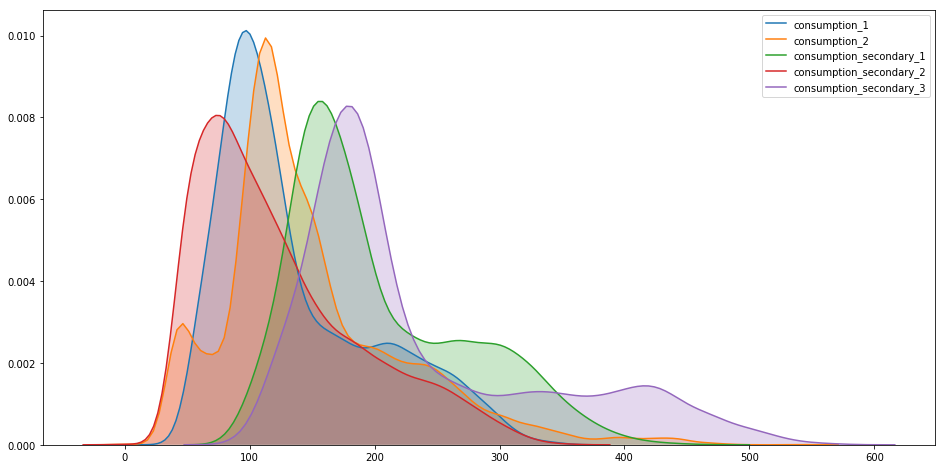

In [18]:
plt.figure(figsize=(16, 8))
sns.kdeplot(df_out['consumption_1'], shade=True) #, label = 'consumption_1')
sns.kdeplot(df_out['consumption_2'], shade=True) #, label = 'consumption_2')
sns.kdeplot(df['consumption_secondary_1'], shade=True) #, label = 'consumption_1')
sns.kdeplot(df['consumption_secondary_2'], shade=True) #, label = 'consumption_1')
sns.kdeplot(df['consumption_secondary_3'], shade=True) #, label = 'consumption_1')
plt.show()

## Consumption variation during time

In [19]:
df.groupby(['hour'])['consumption_secondary_1'].mean().values

array([160.77534247, 160.8739726 , 160.5260274 , 160.83835616,
       161.46027397, 168.88767123, 191.30136986, 210.9369863 ,
       228.49863014, 248.32328767, 256.64657534, 256.21369863,
       240.23287671, 238.76438356, 244.09041096, 242.99178082,
       237.61643836, 227.66027397, 208.08767123, 195.21917808,
       182.35068493, 166.50958904, 161.92054795, 161.87671233])

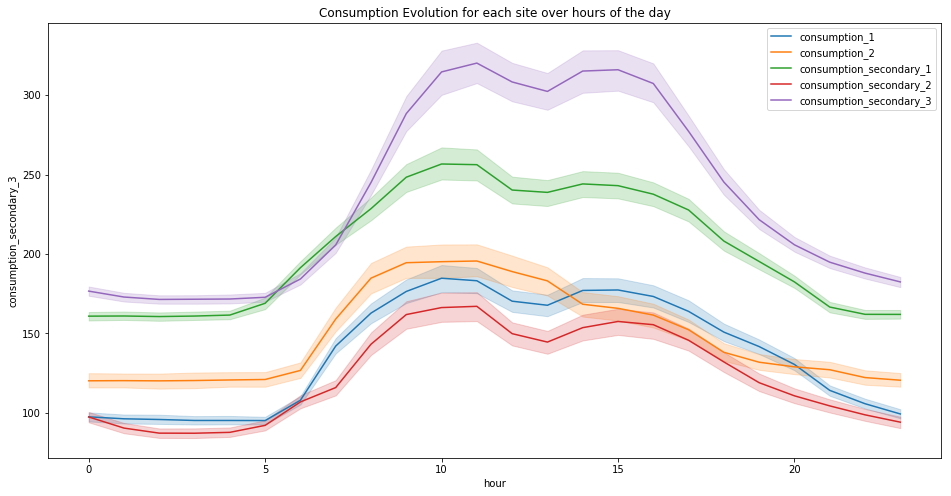

In [20]:
df_viz = pd.concat((df, df_out), axis=1)
plt.figure(figsize=(16, 8))
plt.title("Consumption Evolution for each site over hours of the day")
for c in ['consumption_1', 'consumption_2', 'consumption_secondary_1', 'consumption_secondary_2', 'consumption_secondary_3']:
    sns.lineplot(x="hour", y=c, data=df_viz, label=c)
plt.show()

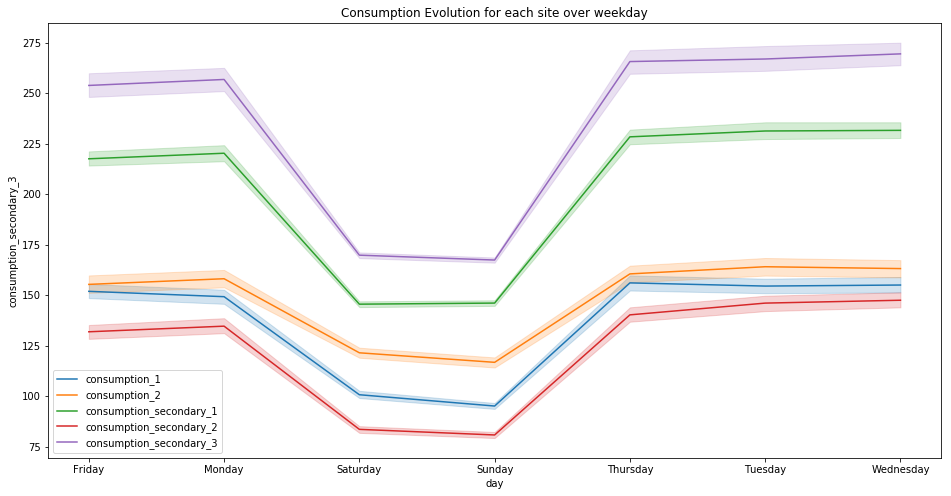

In [21]:
plt.figure(figsize=(16, 8))
plt.title("Consumption Evolution for each site over weekday")
for c in ['consumption_1', 'consumption_2', 'consumption_secondary_1', 'consumption_secondary_2', 'consumption_secondary_3']:
    sns.lineplot(x="day", y=c, data=df_viz, label=c)
plt.show()

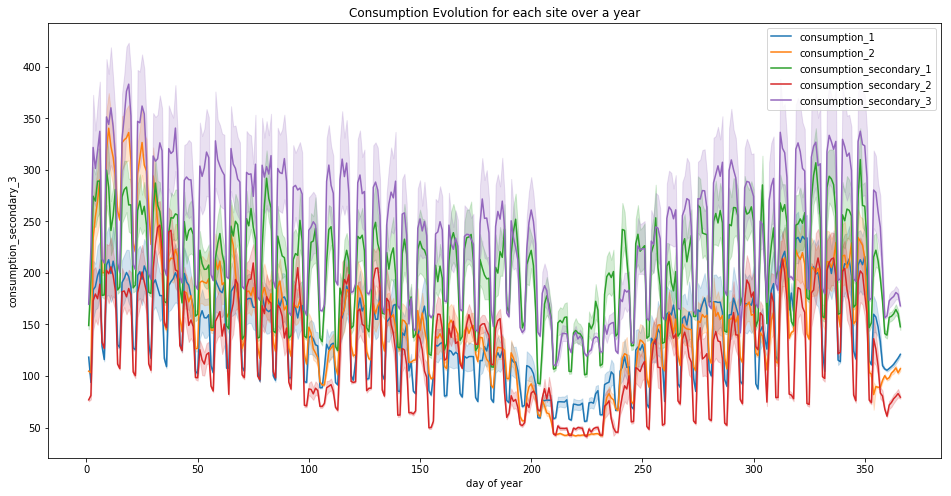

In [22]:
plt.figure(figsize=(16, 8))
plt.title("Consumption Evolution for each site over a year")
for c in ['consumption_1', 'consumption_2', 'consumption_secondary_1', 'consumption_secondary_2', 'consumption_secondary_3']:
    sns.lineplot(x="day of year", y=c, data=df_viz, label=c)
plt.show()

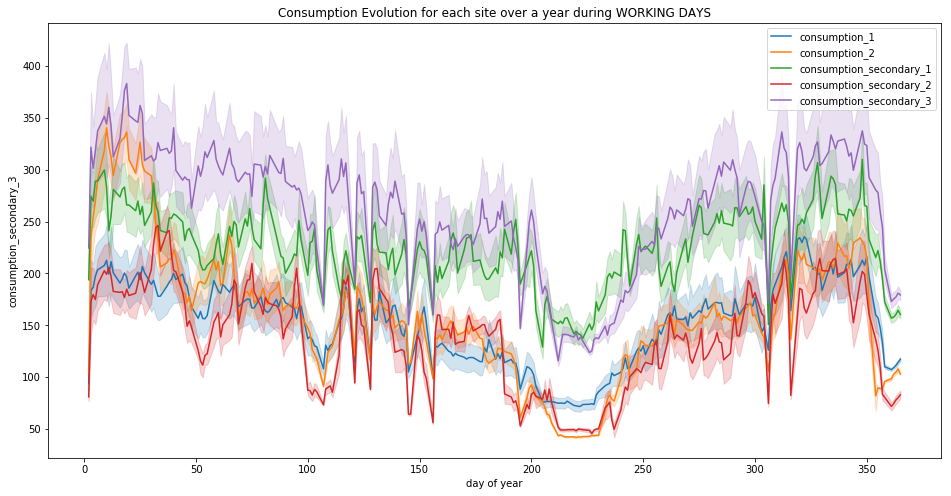

In [23]:
plt.figure(figsize=(16, 8))
plt.title("Consumption Evolution for each site over a year during WORKING DAYS")
for c in ['consumption_1', 'consumption_2', 'consumption_secondary_1', 'consumption_secondary_2', 'consumption_secondary_3']:
    sns.lineplot(x="day of year", y=c, data=df_viz[~df_viz['day'].isin(['Saturday', 'Sunday'])], label=c)
plt.show()

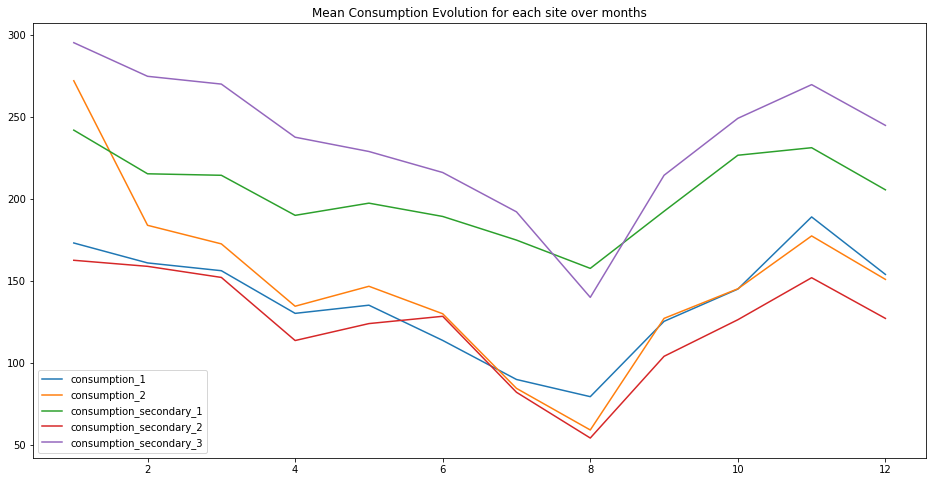

In [24]:
plt.figure(figsize=(16, 8))
plt.title("Mean Consumption Evolution for each site over months")
for c in ['consumption_1', 'consumption_2', 'consumption_secondary_1', 'consumption_secondary_2', 'consumption_secondary_3']:
    sns.lineplot(data=df_viz.groupby(['month'])[c].mean(), label=c)
plt.show()

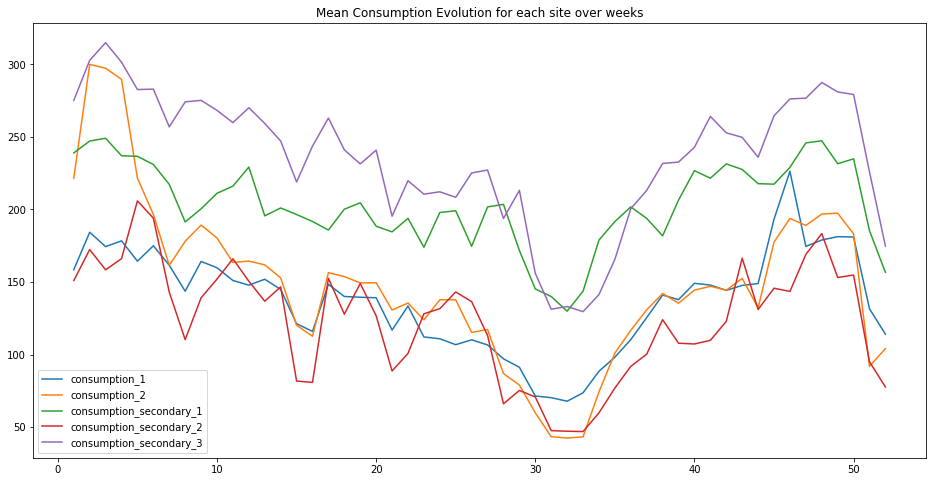

In [25]:
plt.figure(figsize=(16, 8))
plt.title("Mean Consumption Evolution for each site over weeks")
for c in ['consumption_1', 'consumption_2', 'consumption_secondary_1', 'consumption_secondary_2', 'consumption_secondary_3']:
    sns.lineplot(data=df_viz.groupby(['week of year'])[c].mean(), label=c)
plt.show()

/home/sunflowa/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/sunflowa/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


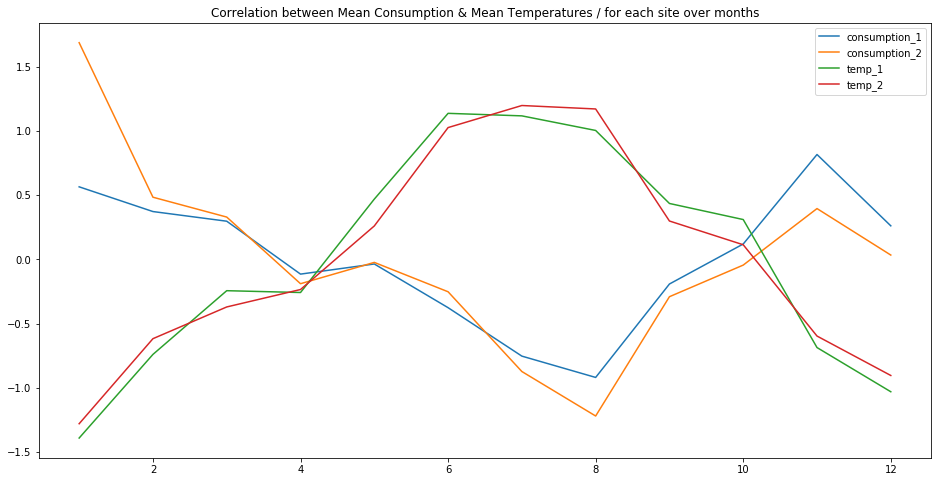

In [26]:
temp_consumption_cols = ['consumption_1', 'consumption_2', 'temp_1', 'temp_2']
df_viz[temp_consumption_cols] = StandardScaler().fit_transform(df_viz[temp_consumption_cols])

plt.figure(figsize=(16, 8))
plt.title("Correlation between Mean Consumption & Mean Temperatures / for each site over months")
for c in temp_consumption_cols:
    sns.lineplot(data=df_viz.groupby(['month'])[c].mean(), label=c)
plt.show()

---

# Features Engineering

## Special dates - non working days "Jours fériés" 
(credits: Antoine Augusti https://github.com/AntoineAugusti/jours-feries-france)

In [27]:
jf = pd.read_csv(os.path.join(file_path, 'jours_feries_seuls.csv')).drop(columns=['nom_jour_ferie'])
# the date column is kept as a string for merging purposes
jf['est_jour_ferie'] = jf['est_jour_ferie'].astype('int')
jf.tail()

,date,est_jour_ferie
1102,2050-07-14,1
1103,2050-08-15,1
1104,2050-11-01,1
1105,2050-11-11,1
1106,2050-12-25,1


In [28]:
jf.est_jour_ferie.unique()

array([1])

## Holidays 
(credits: Antoine Augusti https://www.data.gouv.fr/fr/datasets/vacances-scolaires-par-zones/)

In [29]:
holidays = pd.read_csv(os.path.join(file_path, 'vacances-scolaires.csv')).drop(columns=['nom_vacances'])
# the date column is kept as a string for merging purposes
for col in ['vacances_zone_a', 'vacances_zone_b', 'vacances_zone_c']:
    holidays[col] = holidays[col].astype('int')
holidays.tail()

,date,vacances_zone_a,vacances_zone_b,vacances_zone_c
11318,2020-12-27,0,0,0
11319,2020-12-28,0,0,0
11320,2020-12-29,0,0,0
11321,2020-12-30,0,0,0
11322,2020-12-31,0,0,0


## Sunlight hours
work in progress, more to come in the next days...stay tuned :)

## Merging all infos

In [30]:
def merge_infos(data_frame):
    data_frame = pd.merge(data_frame, holidays, on='date', how='left')
    data_frame = pd.merge(data_frame, jf, on='date', how='left')
    return data_frame

In [31]:
df = merge_infos(df)
df.vacances_zone_a.value_counts()/24

0    243.958333
1    121.041667
Name: vacances_zone_a, dtype: float64

In [32]:
df.est_jour_ferie.value_counts()/24

1.0    11.0
Name: est_jour_ferie, dtype: float64

# Cleaning Data

In [33]:
def cleaning_data(data_frame):

    # The Nan values of the column "est_jour_ferie" correspond to working days 
    # because in the dataset merged with, there is only non working days 
    data_frame['est_jour_ferie'] = data_frame['est_jour_ferie'].fillna(0)
    
    # At first, missing values in the temperatures and humidity columns are replaced by the median ones
    # later another approach with open data of means of the corresponding months will be used
    for c in ['temp_1', 'temp_2', 'humidity_1', 'humidity_2']:
        data_frame[c] = data_frame[c].fillna(data_frame[c].median())
        
    return data_frame

In [34]:
df = cleaning_data(df)
df.isnull().sum()

timestamp                  0
temp_1                     0
temp_2                     0
mean_national_temp         0
humidity_1                 0
humidity_2                 0
loc_1                      0
loc_2                      0
loc_secondary_1            0
loc_secondary_2            0
loc_secondary_3            0
consumption_secondary_1    0
consumption_secondary_2    0
consumption_secondary_3    0
datetime                   0
month                      0
week of year               0
day of year                0
day                        0
hour                       0
date                       0
vacances_zone_a            0
vacances_zone_b            0
vacances_zone_c            0
est_jour_ferie             0
dtype: int64

In [35]:
df.head()

,timestamp,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,loc_1,loc_2,loc_secondary_1,loc_secondary_2,loc_secondary_3,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,datetime,month,week of year,day of year,day,hour,date,vacances_zone_a,vacances_zone_b,vacances_zone_c,est_jour_ferie
0,2016-11-01T00:00:00.0,8.3,14.5,11.1,95.0,65.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",143,74,168,2016-11-01 00:00:00,11,44,306,Tuesday,0,2016-11-01,1,1,1,1.0
1,2016-11-01T01:00:00.0,8.0,14.5,11.1,98.0,65.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",141,60,162,2016-11-01 01:00:00,11,44,306,Tuesday,1,2016-11-01,1,1,1,1.0
2,2016-11-01T02:00:00.0,6.8,14.5,11.0,97.0,65.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",142,60,164,2016-11-01 02:00:00,11,44,306,Tuesday,2,2016-11-01,1,1,1,1.0
3,2016-11-01T03:00:00.0,7.5,14.5,10.9,99.0,65.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",139,60,162,2016-11-01 03:00:00,11,44,306,Tuesday,3,2016-11-01,1,1,1,1.0
4,2016-11-01T04:00:00.0,6.1,14.5,10.8,98.0,65.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",154,60,164,2016-11-01 04:00:00,11,44,306,Tuesday,4,2016-11-01,1,1,1,1.0


---

# Correlations

In [36]:
# after dummies
# sns.pairplot(df_viz.select_dtypes(['int64', 'float64']))#.apply(pd.Series.nunique, axis=0)

In [37]:
df_viz = pd.concat((df, df_out), axis=1)
corr = df_viz.corr()

# makes all correlations positive for the heatmap
corr = np.sqrt(corr * corr)

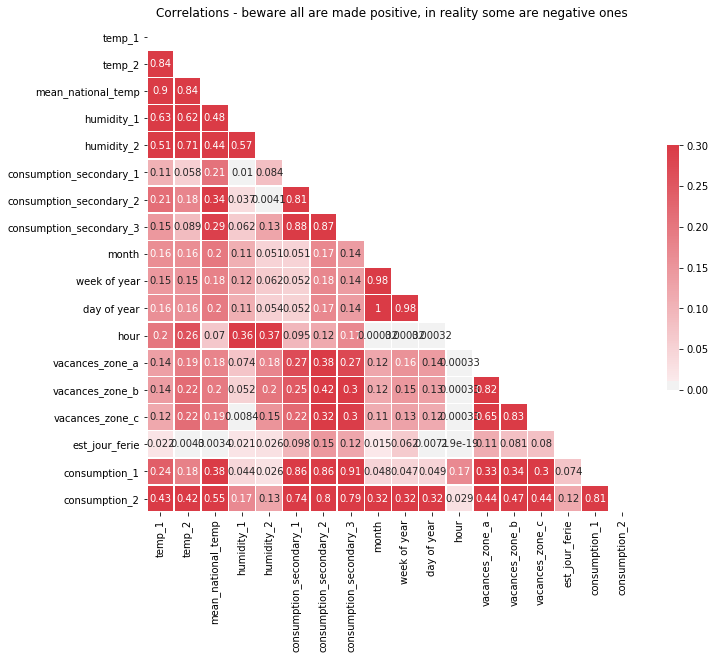

In [38]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plt.title('Correlations - beware all are made positive, in reality some are negative ones')
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

---

# Usual ML Models Training

## Metric / Benchmark

More explanations coming soon...

In [39]:
# Simplified version without loading csv for testing purposes on train sets
def weighted_mean_absolute_error(y_true, y_pred):
    c12 = np.array([1136987, 1364719])
    return 2 * mean_absolute_error(y_true*c12[0], y_pred*c12[1]) / np.sum(c12)

On the assumption that a safety reserve of 20% is needed to covert the supply

In [40]:
def print_metric_on_train(fitted_model_1, fitted_model_2):
    y_train_pred_1, y_train_pred_2 = fitted_model_1.predict(X_train_1), fitted_model_2.predict(X_train_2)
    # arg = dataframe_1_y_true, dataframe_2_y_pred
    print(f'weighted_mean_absolute_error on X_train_1 : {weighted_mean_absolute_error(y_train_1, y_train_pred_1)}')
    print(f'weighted_mean_absolute_error on X_train_2 : {weighted_mean_absolute_error(y_train_2, y_train_pred_2)}')

There is a difference in the length of the two dataframes X_train & X_test

## Comparison between X_train & X_test

In [41]:
X_test = pd.read_csv(os.path.join(file_path, 'input_test_cdKcI0e.csv'), index_col='ID')
X_test.iloc[23:26]

,timestamp,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,loc_1,loc_2,loc_secondary_1,loc_secondary_2,loc_secondary_3,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3
ID,,,,,,,,,,,,,,
8783,2017-11-01T23:00:00.0,9.0,9.0,9.4,78.0,95.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",172,131,170
8784,2017-11-02T00:00:00.0,8.8,8.6,9.4,79.0,95.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",172,136,172
8785,2017-11-02T01:00:00.0,7.6,8.8,9.4,82.0,96.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",174,126,171


In [42]:
df.shape[0], X_test.shape[0]

(8760, 8736)

Actually, the number of days in a year is different

In [43]:
df.iloc[[0, -1]]

,timestamp,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,loc_1,loc_2,loc_secondary_1,loc_secondary_2,loc_secondary_3,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,datetime,month,week of year,day of year,day,hour,date,vacances_zone_a,vacances_zone_b,vacances_zone_c,est_jour_ferie
0,2016-11-01T00:00:00.0,8.3,14.5,11.1,95.0,65.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",143,74,168,2016-11-01 00:00:00,11,44,306,Tuesday,0,2016-11-01,1,1,1,1.0
8759,2017-10-31T23:00:00.0,7.0,7.9,8.8,90.0,78.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",198,128,189,2017-10-31 23:00:00,10,44,304,Tuesday,23,2017-10-31,1,1,1,0.0


In [44]:
X_test.iloc[[0, -1]]

,timestamp,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,loc_1,loc_2,loc_secondary_1,loc_secondary_2,loc_secondary_3,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3
ID,,,,,,,,,,,,,,
8760,2017-11-01T00:00:00.0,6.5,7.1,8.8,91.0,82.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",190,126,177
17495,2018-10-30T23:00:00.0,7.5,11.2,6.7,85.0,77.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",228,114,178


In [45]:
df = df[:-24]
df.shape, X_test.shape

((8736, 25), (8736, 14))

In [46]:
df_out = df_out[:-24]

In [47]:
#for c in feat_to_dummies:
#    print(c, 'nb uniques X_train / X_test:', len(df[c].unique()), ' /', len(X_test[c].unique()))

## Data preparation

In [48]:
feat_to_drop = [
'timestamp',
'loc_1',
'loc_2',
'loc_secondary_1',
'loc_secondary_2',
'loc_secondary_3',
'datetime',
'date']

In [49]:
feat_to_scale = [
'temp_1',
'temp_2',
'mean_national_temp',
'humidity_1',
'humidity_2',
'consumption_secondary_1',
'consumption_secondary_2',
'consumption_secondary_3']

In [50]:
feat_to_dummies = [
'day',
'month',
'week of year',
#'day of year',
'hour']

Side note : let's try to run models without dummification of day of year

In [51]:
def prepare_feat_df(data_frame):
    data_frame = data_frame.drop(columns=feat_to_drop)
    data_frame[feat_to_scale] = StandardScaler().fit_transform(data_frame[feat_to_scale])
    data_frame = pd.get_dummies(data=data_frame, columns=feat_to_dummies, drop_first=True)
    return data_frame

In [52]:
df = prepare_feat_df(df)
df.head(2)

/home/sunflowa/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/sunflowa/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,day of year,vacances_zone_a,vacances_zone_b,vacances_zone_c,est_jour_ferie,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,week of year_2,week of year_3,week of year_4,week of year_5,week of year_6,week of year_7,week of year_8,week of year_9,week of year_10,week of year_11,week of year_12,week of year_13,week of year_14,week of year_15,week of year_16,week of year_17,week of year_18,week of year_19,week of year_20,week of year_21,...,week of year_26,week of year_27,week of year_28,week of year_29,week of year_30,week of year_31,week of year_32,week of year_33,week of year_34,week of year_35,week of year_36,week of year_37,week of year_38,week of year_39,week of year_40,week of year_41,week of year_42,week of year_43,week of year_44,week of year_45,week of year_46,week of year_47,week of year_48,week of year_49,week of year_50,week of year_51,week of year_52,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,-0.444697,-0.068538,-0.321306,1.066646,0.068894,-0.858454,-0.760339,-0.678913,306,1,1,1,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-0.487636,-0.068538,-0.321306,1.248537,0.068894,-0.887165,-0.975449,-0.739044,306,1,1,1,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Split Train for 2 regressions

In [53]:
def split_df(df_X, df_y):
        X_train_1 = df_X.drop(columns=['temp_2', 'humidity_2'])
        X_train_2 = df_X.drop(columns=['temp_1', 'humidity_1'])
        y_train_1 = df_y['consumption_1']
        y_train_2 = df_y['consumption_2']
        return X_train_1, X_train_2, y_train_1, y_train_2

In [54]:
X_train_1, X_train_2, y_train_1, y_train_2 = split_df(df, df_out)
X_train_1.shape, X_train_2.shape, y_train_1.shape, y_train_2.shape

((8736, 102), (8736, 102), (8736,), (8736,))

In [55]:
y_train_1.shape, y_train_2.shape

((8736,), (8736,))

## Preparation of X_test

In [56]:
X_test = transform_datetime_infos(X_test)
X_test = merge_infos(X_test)
X_test = cleaning_data(X_test)
X_test = prepare_feat_df(X_test)

/home/sunflowa/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/sunflowa/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [57]:
X_test_1 = X_test.drop(columns=['temp_2', 'humidity_2'])
X_test_2 = X_test.drop(columns=['temp_1', 'humidity_1'])

## Base lines with current SKlearn models

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

* samples nb > 100k
    * SGD regressor
* samples nb < 100k
    * Few features should be important : YES:
        * Lasso
        * ElasticNet
    * Few features should be important : NO:
        * RidgeRegression
        * SVR(kernel='linear')
        If not working
        * SVR(kernel='rbf')
        * Ensemble regressor

In [59]:
X_train_1.shape, X_train_2.shape, X_test_1.shape, X_test_2.shape

((8736, 102), (8736, 102), (8736, 102), (8736, 102))

In [60]:
def create_submission(fitted_model_1, fitted_model_2, model_name):

    y_pred_1 = fitted_model_1.predict(X_test_1).astype(int)
    y_pred_2 = fitted_model_2.predict(X_test_2).astype(int)

    #y_pred_1, y_pred_2 = 1.2 * y_pred_1, 1.2 * y_pred_2 # no need of 20% more
    res = pd.DataFrame(np.stack((y_pred_1, y_pred_2)).T, columns=['consumption_1', 'consumption_2'])
    res = res.set_index(pd.Index(range(8760, 17496)))
    res.index.name = 'ID'
    
    name = 'y_test_' + model_name + '_.csv' 
    res.to_csv(name, sep=',', index=True)

### Linear reg

In [61]:
linear_base_1, linear_base_2 = LinearRegression(), LinearRegression()
linear_base_1.fit(X_train_1, y_train_1)
linear_base_2.fit(X_train_2, y_train_2)
print_metric_on_train(linear_base_1, linear_base_2)

weighted_mean_absolute_error on X_train_1 : 26.05154994411465
weighted_mean_absolute_error on X_train_2 : 28.70569128856438


In [62]:
create_submission(linear_base_1, linear_base_2, 'linear_reg')

Your submission score is : ?

### Lasso

In [63]:
lasso_base_1, lasso_base_2 = Lasso(alpha=0.01, max_iter=10e5), Lasso(alpha=0.01, max_iter=10e5)
lasso_base_1.fit(X_train_1, y_train_1)
lasso_base_2.fit(X_train_2, y_train_2)
print_metric_on_train(lasso_base_1, lasso_base_2)

weighted_mean_absolute_error on X_train_1 : 26.059484283814665
weighted_mean_absolute_error on X_train_2 : 28.729028522103892


In [64]:
create_submission(lasso_base_1, lasso_base_2, 'lasso')

Your submission score is : 23.70

### ElasticNet

In [65]:
elast_base_1, elast_base_2 = ElasticNet(alpha=0.01, max_iter=10e8), ElasticNet(alpha=0.1, max_iter=10e8)
elast_base_1.fit(X_train_1, y_train_1)
elast_base_2.fit(X_train_2, y_train_2)
print_metric_on_train(elast_base_1, elast_base_2)

weighted_mean_absolute_error on X_train_1 : 26.122265350907263
weighted_mean_absolute_error on X_train_2 : 29.45944931510414


In [66]:
create_submission(elast_base_1, elast_base_2, 'elastic_net')

Your submission score is : ????

### RidgeRegression

In [68]:
ridge_base_1, ridge_base_2 = Ridge(alpha=0.1, max_iter=10e10), Ridge(alpha=0.1, max_iter=10e10)
ridge_base_1.fit(X_train_1, y_train_1)
ridge_base_2.fit(X_train_2, y_train_2)
print_metric_on_train(ridge_base_1, ridge_base_2)

weighted_mean_absolute_error on X_train_1 : 26.05165918159416
weighted_mean_absolute_error on X_train_2 : 28.701878932436024


In [69]:
create_submission(ridge_base_1, ridge_base_2, 'ridge_reg')

Your submission score is : ????

### Adaboost Regressor

In [71]:
adaboost_base_1, adaboost_base_2 = AdaBoostRegressor(), AdaBoostRegressor()
adaboost_base_1.fit(X_train_1, y_train_1)
adaboost_base_2.fit(X_train_2, y_train_2)
print_metric_on_train(adaboost_base_1, adaboost_base_2)

weighted_mean_absolute_error on X_train_1 : 42.422147818506104
weighted_mean_absolute_error on X_train_2 : 46.1059420804167


In [72]:
create_submission(adaboost_base_1, adaboost_base_2, 'adaboost_reg')

Your submission score is : ????

### SVR(kernel='linear')

In [74]:
svr_base_1 = SVR(kernel='linear')
svr_base_2 = SVR(kernel='linear')
svr_base_1.fit(X_train_1, y_train_1)
svr_base_2.fit(X_train_2, y_train_2)
print_metric_on_train(svr_base_1, svr_base_2)

weighted_mean_absolute_error on X_train_1 : 25.190223562511903
weighted_mean_absolute_error on X_train_2 : 27.284751185110952


In [75]:
create_submission(svr_base_1, svr_base_2, 'svr_lin')

Your submission score is : ????

### SVR(kernel='rbf')

In [ ]:
#svr_base_1 = SVR(kernel='rbf', degree=3, gamma='auto_deprecated', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
svr_base_1 = SVR(kernel='rbf')
svr_base_2 = SVR(kernel='rbf')
svr_base_1.fit(X_train_1, y_train_1)
svr_base_2.fit(X_train_2, y_train_2)
print_metric_on_train(svr_base_1, svr_base_2)

In [ ]:
create_submission(svr_base_1, svr_base_2, 'svr_rbf')

Your submission score is : ????

In [ ]:
#svr_poly_1 = SVR(kernel='poly')
#svr_poly_2 = SVR(kernel='poly')
#svr_poly_1.fit(X_train_1, y_train_1)
#svr_poly_2.fit(X_train_2, y_train_2)
#print_metric_on_train(svr_poly_1, svr_poly_2)
#create_submission(svr_poly_1, svr_poly_2, 'svr_poly')

---

# Using Recurrent Neural Networks

## Simple RNN

In [114]:
X_train = pd.read_csv(os.path.join(file_path, 'input_training_ssnsrY0.csv'), index_col='ID')
X_test  = pd.read_csv(os.path.join(file_path, 'input_test_cdKcI0e.csv'), index_col='ID')
y_train = pd.read_csv(os.path.join(file_path, 'output_training_Uf11I9I.csv'), index_col='ID')

In [115]:
X_train, X_test = transform_datetime_infos(X_train), transform_datetime_infos(X_test)
X_train, X_test = merge_infos(X_train), merge_infos(X_test)
X_train, X_test = cleaning_data(X_train), cleaning_data(X_test)
X_train, X_test = prepare_feat_df(X_train), prepare_feat_df(X_test)

/home/sunflowa/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/sunflowa/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/sunflowa/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/sunflowa/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [116]:
X_train.shape, X_test.shape, y_train.shape

((8760, 104), (8736, 104), (8760, 2))

In [117]:
X_train_rnn = np.expand_dims(np.array(X_train.iloc[:48, :]), axis=0)

i = 49
while i < X_train.shape[0]:
    X_temp = np.expand_dims(np.array(X_train.iloc[(i-48):i, :]), axis=0)
    X_train_rnn = np.concatenate((X_train_rnn, X_temp), axis=0)
    i += 1

In [118]:
y_train = y_train.iloc[48:]
X_train_rnn.shape, y_train.shape

((8712, 48, 104), (8712, 2))

In [129]:
shape = X_train_rnn.shape
shape

(8712, 48, 104)

In [130]:
X_train_rnn = X_train_rnn.reshape(shape[0], -1)

In [131]:
scaler = StandardScaler()

In [132]:
X_train_rnn = scaler.fit_transform(X_train_rnn)

In [133]:
X_train_rnn = X_train_rnn.reshape(shape[0], shape[1], shape[2])
X_train_rnn.shape

(8712, 48, 104)

In [134]:
X_test_init = X_train[-48:]
X_test_init.shape

(48, 104)

In [135]:
X_test_temp = pd.concat([X_test_init, X_test])
X_test_temp.shape

(8784, 104)

In [136]:
X_test_rnn = np.expand_dims(np.array(X_test_temp.iloc[:48, :]), axis=0)

i = 49
while i < X_test_temp.shape[0]:
    X_temp = np.expand_dims(np.array(X_test_temp.iloc[(i-48):i, :]), axis=0)
    X_test_rnn = np.concatenate((X_test_rnn, X_temp), axis=0)
    i += 1

X_test_rnn.shape

(8736, 48, 104)

In [137]:
shape = X_test_rnn.shape
shape

(8736, 48, 104)

In [138]:
X_test_rnn = X_test_rnn.reshape(shape[0], -1)

In [139]:
X_test_rnn = scaler.transform(X_test_rnn)

In [140]:
X_test_rnn = X_test_rnn.reshape(shape[0], shape[1], shape[2])

In [141]:
X_test_rnn.shape

(8736, 48, 104)

In [142]:
def my_simple_RNN():
    model = Sequential()
    model.add(SimpleRNN(units=32, return_sequences=True))
    model.add(SimpleRNN(units=32, return_sequences=False))
    model.add(Dense(units=1, activation='linear'))
    return model

In [145]:
simple_rnn_1, simple_rnn_2 = my_simple_RNN(), my_simple_RNN()
simple_rnn_1.compile(optimizer='SGD', loss='mean_squared_error')
simple_rnn_2.compile(optimizer='SGD', loss='mean_squared_error')

In [148]:
X_train_rnn.shape, y_train.shape

((8712, 48, 104), (8712, 2))

In [151]:
simple_rnn_1.fit(x=X_train_rnn, y=np.array(y_train.iloc[:,0]), epochs=20, batch_size=32)

Epoch 1/10
8712/8712 [==============================] - 10s 1ms/sample - loss: 3117.8332
Epoch 2/10
8712/8712 [==============================] - 7s 829us/sample - loss: 3030.9727
Epoch 3/10
8712/8712 [==============================] - 7s 861us/sample - loss: 2803.4922
Epoch 4/10
8712/8712 [==============================] - 8s 942us/sample - loss: 2809.6149
Epoch 5/10
8712/8712 [==============================] - 8s 971us/sample - loss: 2962.2890
Epoch 6/10
8712/8712 [==============================] - 10s 1ms/sample - loss: 2836.1289
Epoch 7/10
8712/8712 [==============================] - 11s 1ms/sample - loss: 2798.5867
Epoch 8/10
8712/8712 [==============================] - 10s 1ms/sample - loss: 2857.0780
Epoch 9/10
8712/8712 [==============================] - 11s 1ms/sample - loss: 2681.8532
Epoch 10/10
8712/8712 [==============================] - 10s 1ms/sample - loss: 2089.8970


In [152]:
simple_rnn_2.fit(x=X_train_rnn, y=np.array(y_train.iloc[:,1]), epochs=20, batch_size=32)

Epoch 1/20
8712/8712 [==============================] - 10s 1ms/sample - loss: 6381.2999
Epoch 2/20
8712/8712 [==============================] - 10s 1ms/sample - loss: 3073.7097
Epoch 3/20
8712/8712 [==============================] - 9s 1ms/sample - loss: 2933.0987
Epoch 4/20
8712/8712 [==============================] - 9s 1ms/sample - loss: 2664.1874
Epoch 5/20
8712/8712 [==============================] - 9s 1ms/sample - loss: 2808.7358
Epoch 6/20
8712/8712 [==============================] - 8s 964us/sample - loss: 2714.0116
Epoch 7/20
8712/8712 [==============================] - 10s 1ms/sample - loss: 2652.2752
Epoch 8/20
8712/8712 [==============================] - 10s 1ms/sample - loss: 2594.7759
Epoch 9/20
8712/8712 [==============================] - 9s 993us/sample - loss: 2546.6303
Epoch 10/20
8712/8712 [==============================] - 8s 958us/sample - loss: 2479.7891
Epoch 11/20
8712/8712 [==============================] - 9s 1ms/sample - loss: 2522.1653
Epoch 12/20
8712/871

In [155]:
y_train_pred_1 = simple_rnn_1.predict(X_train_rnn)
y_train_pred_2 = simple_rnn_2.predict(X_train_rnn)
y_test_pred_1  = simple_rnn_1.predict(X_test_rnn)
y_test_pred_2  = simple_rnn_2.predict(X_test_rnn)

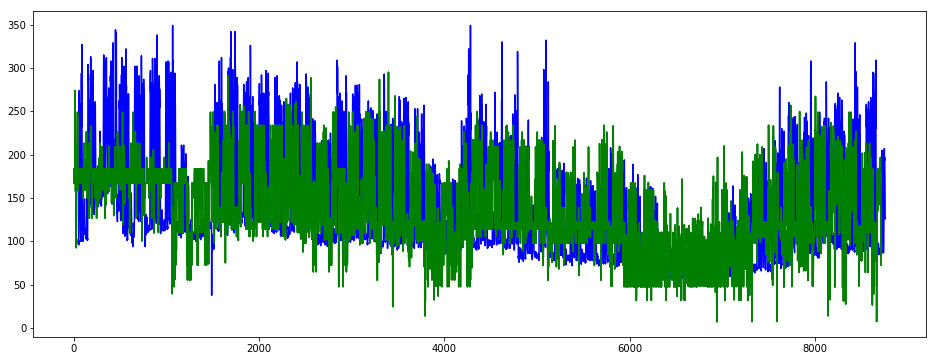

In [160]:
plt.figure(figsize=(16, 6))
plt.plot(y_train.iloc[:, 0], color='blue')
plt.plot(y_train_pred_1, color='green')
plt.show()

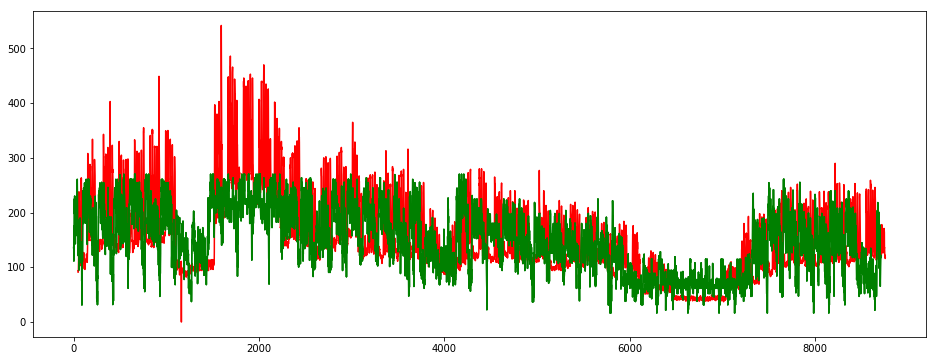

In [158]:
plt.figure(figsize=(16, 6))
plt.plot(y_train.iloc[:, 1], color='red')
plt.plot(y_train_pred_2, color='green')
plt.show()

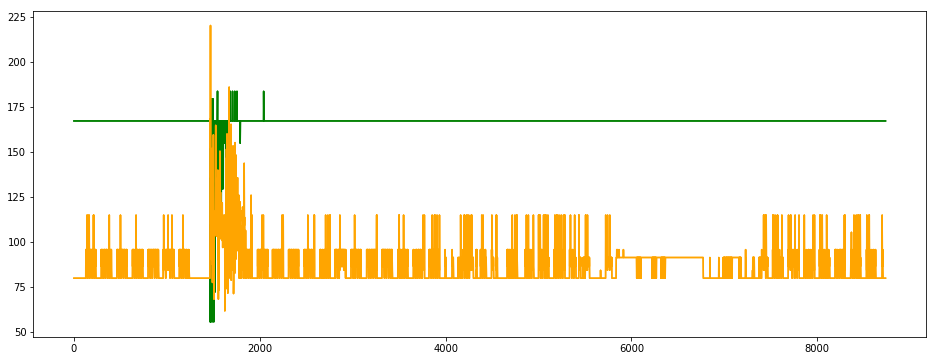

In [162]:
plt.figure(figsize=(16, 6))
plt.plot(y_test_pred_1, color='green')
plt.plot(y_test_pred_2, color='orange')
plt.show()

## GRU

In [164]:
def my_GRU():
    model = Sequential()
    model.add(GRU(units=32, return_sequences=True))
    model.add(GRU(units=32, return_sequences=False))
    model.add(Dense(units=1, activation='linear'))
    return model

In [165]:
gru_1, gru_2 = my_GRU(), my_GRU()
gru_1.compile(optimizer='SGD', loss='mean_squared_error')
gru_2.compile(optimizer='SGD', loss='mean_squared_error')

In [166]:
gru_1.fit(x=X_train_rnn, y=np.array(y_train.iloc[:,0]), epochs=20, batch_size=32)

Epoch 1/20
8712/8712 [==============================] - 32s 4ms/sample - loss: 4128.3984
Epoch 2/20
8712/8712 [==============================] - 31s 4ms/sample - loss: 2869.4865
Epoch 3/20
8712/8712 [==============================] - 31s 4ms/sample - loss: 2793.8875
Epoch 4/20
8712/8712 [==============================] - 30s 3ms/sample - loss: 2705.4210
Epoch 5/20
8712/8712 [==============================] - 31s 4ms/sample - loss: 2667.5134
Epoch 6/20
8712/8712 [==============================] - 31s 4ms/sample - loss: 2612.5178
Epoch 7/20
8712/8712 [==============================] - 31s 4ms/sample - loss: 2624.4466
Epoch 8/20
8712/8712 [==============================] - 31s 4ms/sample - loss: 2767.6757
Epoch 9/20
8712/8712 [==============================] - 29s 3ms/sample - loss: 2870.8577
Epoch 10/20
8712/8712 [==============================] - 31s 4ms/sample - loss: 2852.9966
Epoch 11/20
8712/8712 [==============================] - 30s 3ms/sample - loss: 2844.3963
Epoch 12/20
8712/87

In [167]:
gru_2.fit(x=X_train_rnn, y=np.array(y_train.iloc[:,1]), epochs=20, batch_size=32)

Epoch 1/20
8712/8712 [==============================] - 32s 4ms/sample - loss: 5086.0511
Epoch 2/20
8712/8712 [==============================] - 39s 4ms/sample - loss: 3996.0903
Epoch 3/20
8712/8712 [==============================] - 30s 3ms/sample - loss: 3698.5157
Epoch 4/20
8712/8712 [==============================] - 28s 3ms/sample - loss: 3676.1699
Epoch 5/20
8712/8712 [==============================] - 28s 3ms/sample - loss: 3503.0258
Epoch 6/20
8712/8712 [==============================] - 30s 3ms/sample - loss: 3404.4124
Epoch 7/20
8712/8712 [==============================] - 33s 4ms/sample - loss: 3261.1432
Epoch 8/20
8712/8712 [==============================] - 30s 3ms/sample - loss: 3084.0876
Epoch 9/20
8712/8712 [==============================] - 33s 4ms/sample - loss: 2933.8503
Epoch 10/20
8712/8712 [==============================] - 31s 4ms/sample - loss: 3018.6359
Epoch 11/20
8712/8712 [==============================] - 33s 4ms/sample - loss: 2891.8107
Epoch 12/20
8712/87

In [168]:
y_train_pred_1 = gru_1.predict(X_train_rnn)
y_train_pred_2 = gru_2.predict(X_train_rnn)
y_test_pred_1  = gru_1.predict(X_test_rnn)
y_test_pred_2  = gru_2.predict(X_test_rnn)

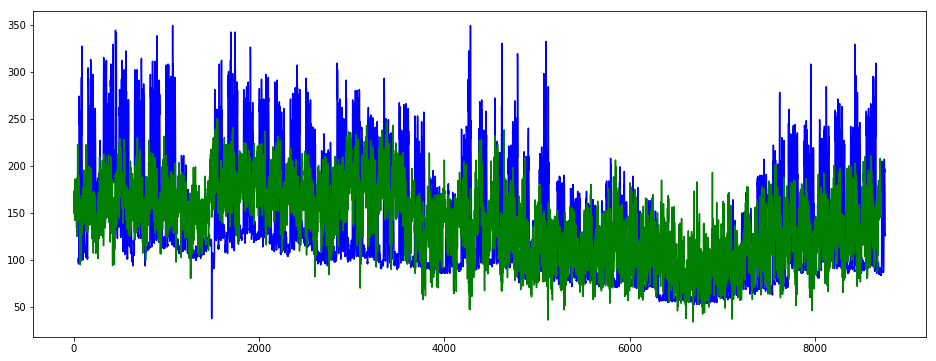

In [169]:
plt.figure(figsize=(16, 6))
plt.plot(y_train.iloc[:, 0], color='blue')
plt.plot(y_train_pred_1, color='green')
plt.show()

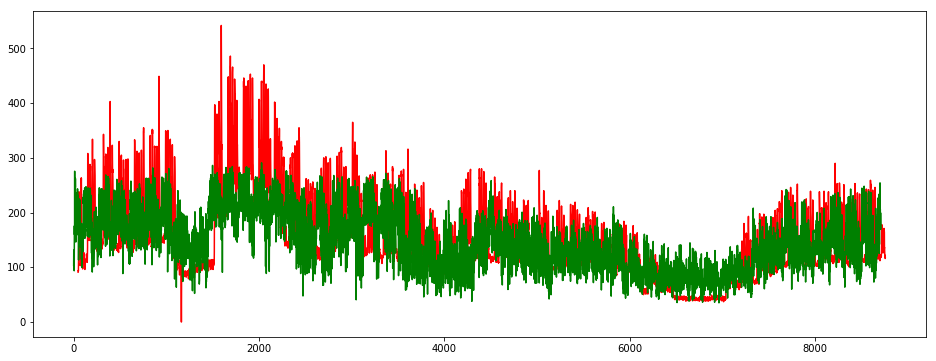

In [170]:
plt.figure(figsize=(16, 6))
plt.plot(y_train.iloc[:, 1], color='red')
plt.plot(y_train_pred_2, color='green')
plt.show()

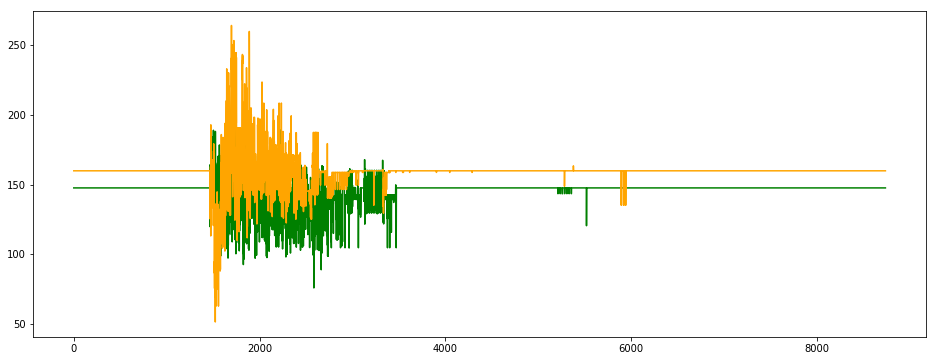

In [171]:
plt.figure(figsize=(16, 6))
plt.plot(y_test_pred_1, color='green')
plt.plot(y_test_pred_2, color='orange')
plt.show()

---

# Ideas

* fill NA with continuous values, mean or median of the week depending where NAs are
* open data for missing temperatures
* add sunlight hours
* try w & w/o get dummies for hours, weekdays
* scaler : fit transform on X/y train & transform on X test
* more function for automation
* RNN
* SARIMA or ARIMA

https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

https://www.kaggle.com/niyamatalmass/machine-learning-for-time-series-analysis
    
https://mapr.com/blog/deep-learning-tensorflow/
    
https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424
    
https://machinelearningmastery.com/how-to-grid-search-deep-learning-models-for-time-series-forecasting/
    
Really interesting post:

https://machinelearningmastery.com/multi-step-time-series-forecasting-with-machine-learning-models-for-household-electricity-consumption/
    
https://medium.com/@alexrachnog/deep-learning-the-final-frontier-for-signal-processing-and-time-series-analysis-734307167ad6
    
https://towardsdatascience.com/time-series-machine-learning-regression-framework-9ea33929009a

---

# TEST

In [ ]:
temp_test = pd.read_csv('y_test.csv', index_col=0)
temp_test.shape

In [ ]:
temp_true = pd.read_csv('y_test_true.csv',  index_col=0)

In [ ]:
idx = [8760,  8761,  8762,  8763,  8764,  8765,  8766,  8767,  8768,
             8769,  8770,  8771,  8772,  8773,  8774,  8775,  8776,  8777,
             8778,  8779,  8780,  8781,  8782,  8783,  8784,  8785,  8786,
             8787,  8788,  8789, 17466, 17467, 17468, 17469, 17470, 17471,
            17472, 17473, 17474, 17475, 17476, 17477, 17478, 17479, 17480,
            17481, 17482, 17483, 17484, 17485, 17486, 17487, 17488, 17489,
            17490, 17491, 17492, 17493, 17494, 17495]

In [ ]:
temp_test = temp_test[temp_test.index.isin(idx)]

In [ ]:
pd.concat((temp_true, temp_test), axis=1)

In [ ]:
weighted_mean_absolute_error(temp_true, temp_test)

---

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor, RandomForestRegressor, \
                                ExtraTreesRegressor, AdaBoostRegressor

HistGradientBoostingRegressor : This implementation is inspired by LightGBM.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html#sklearn.ensemble.BaggingRegressor

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html#sklearn.ensemble.ExtraTreesRegressor

https://lightgbm.readthedocs.io/en/latest/Parameters.html